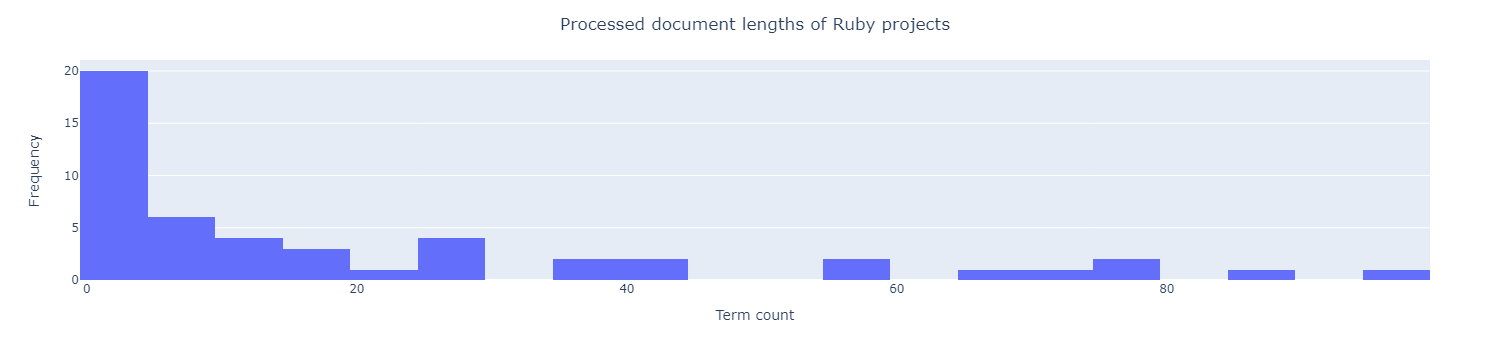

Vocabulary size: 70


In [351]:
import bitermplus as btm
import numpy as np
import pandas as pd
import statistics
import scipy.stats
import optuna
import plotly.express as px
import tqdm
import itertools
import tmplot as tmp

language = "Ruby"

def contexts_to_text(contexts):
    return " ".join([" ".join(context) + "." for context in eval(contexts)])

def count_total_terms(contexts):
    return sum([len(context) for context in eval(contexts)])

repos = pd.read_csv(f"processed_readmes_{language.lower()}.csv", sep=";", quotechar="'")

repos["TEXT_PROCESSED"] = repos["CONTEXTS"].transform(contexts_to_text)
repos["LENGTH_PROCESSED"] = repos["CONTEXTS"].transform(count_total_terms)

px.histogram(repos["LENGTH_PROCESSED"].value_counts(), nbins=30, width=600, height=300).update_layout(showlegend=False, title_text=f"Processed document lengths of {language} projects", title_x=0.5, yaxis_title="Frequency", xaxis_title="Term count").show()

texts = repos["TEXT_PROCESSED"]

language_removed_words = {"Go": ["go", "golang"], "Java": ["java"], "Python": ["python"], "Ruby": ["ruby"]}
common_removed_words = ["library", "package"]

X, vocabulary, vocab_dict = btm.get_words_freqs(texts, binary=False, stop_words=language_removed_words[language]+common_removed_words, min_df=0.02) # It can take whatever parameter CounterVectorizer can take: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
biterms = btm.get_biterms(docs_vec)

print("Vocabulary size:", len(vocabulary))

In [334]:
"""
In general, higher alpha values mean documents contain more similar topic contents. 
The same is true for beta, but with topics and words: generally a high beta will result in topics with more similar word contents. 
Also, an asymmetric alpha is helpful, where as an asymmetric beta is largely not.
"""

model = btm.BTM(X, vocabulary, seed=42, T=50, M=5, win=500, alpha=1/100, beta=0.01, has_background=False)
model.fit(biterms, iterations=1000)

coherences = np.exp(model.coherence_)

print(model.perplexity_)
print(min(coherences))
print(max(coherences))
print(statistics.mean(coherences))
print(statistics.median(coherences))
print(statistics.stdev(coherences)/statistics.mean(coherences))
print(btm.entropy(model.matrix_topics_words_))

scipy.stats.describe(coherences)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.84it/s]


1.0
1.1715596941388936e-13
1.112950486975846e-07
2.9061392686277528e-09
3.208320257498053e-11
5.496499832923376
4.037804699735749


DescribeResult(nobs=50, minmax=(1.1715596941388936e-13, 1.112950486975846e-07), mean=2.9061392686277524e-09, variance=2.5515570541946434e-16, skewness=6.476027184472256, kurtosis=41.19938129461358)

In [8]:
median_coherence = statistics.median(coherences)
mean_coherence = statistics.mean(coherences)


for i, coherence in enumerate(coherences):
    if coherence >= mean_coherence:
        print(i, coherence)

0 0.005660585959093421
3 0.002960322764288014
8 0.003901844231062337
10 0.00290249433106576
11 0.010791509621106926
13 0.0069530864197530845
16 0.02739094650205761
19 0.003779289493575207
21 0.012641975308641973
24 0.006928697404887878
27 0.002607407407407407
31 0.004828532235939644
39 0.003779289493575207
48 0.006322571919859348
52 0.002609228147714264
56 0.0036872427983539106
62 0.0028844420407427443
65 0.0030094730002393883
68 0.007812030527011599
72 0.003891652846876726
74 0.002926383173296753
84 0.0029063291663860495
89 0.00630119722747322
90 0.002682763246143527
95 0.0069530864197530845


In [275]:
def objective(trial):
    
    # alpha = trial.suggest_float("alpha", 0.02, 0.2, log=True)
    # beta = trial.suggest_float("beta", 0.005, 0.02, log=True)
    n_topic = trial.suggest_int("n_topic", 5, 50, log=False)
    # has_background = trial.suggest_categorical("has_background", [True, False])
    
    model = btm.BTM(X, vocabulary, seed=42, T=n_topic, M=5, alpha=1/(n_topic*10), beta=0.01, has_background=False)
    model.fit(biterms, iterations=1000, verbose=False)

    return btm.entropy(model.matrix_topics_words_)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_jobs=5, show_progress_bar=True)

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [341]:
numbers_of_topic = list(range(1, 51, 1))
perplexity_results = []
entropy_results = []
min_coherences = []
max_coherences = []
median_coherences = []

for n_topic in tqdm.tqdm(numbers_of_topic):
    # print(n_topic)
    model = btm.BTM(X, vocabulary, seed=42, T=n_topic, M=5, alpha=1/10*n_topic, beta=0.01, has_background=False)
    model.fit(biterms, iterations=600, verbose=False)
    # print(model.perplexity_)
    perplexity_results.append(model.perplexity_)
    
    entropy = btm.entropy(model.matrix_topics_words_)
    entropy_results.append(entropy)
    
    coherences = np.exp(model.coherence_)
    min_coherences.append(min(coherences))
    max_coherences.append(max(coherences))
    median_coherences.append(statistics.median(coherences))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:06<00:00,  3.72s/it]


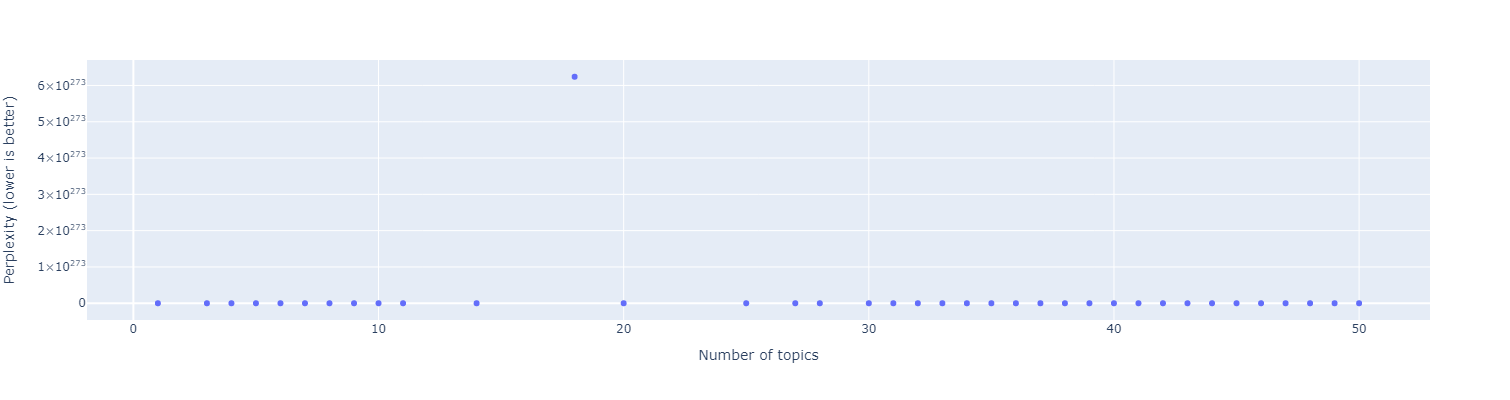

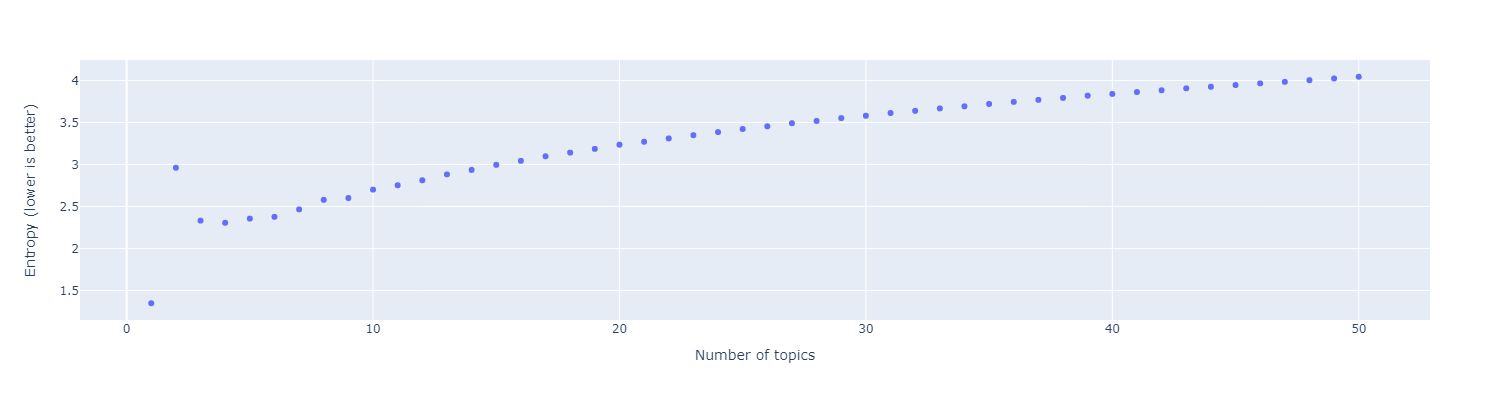

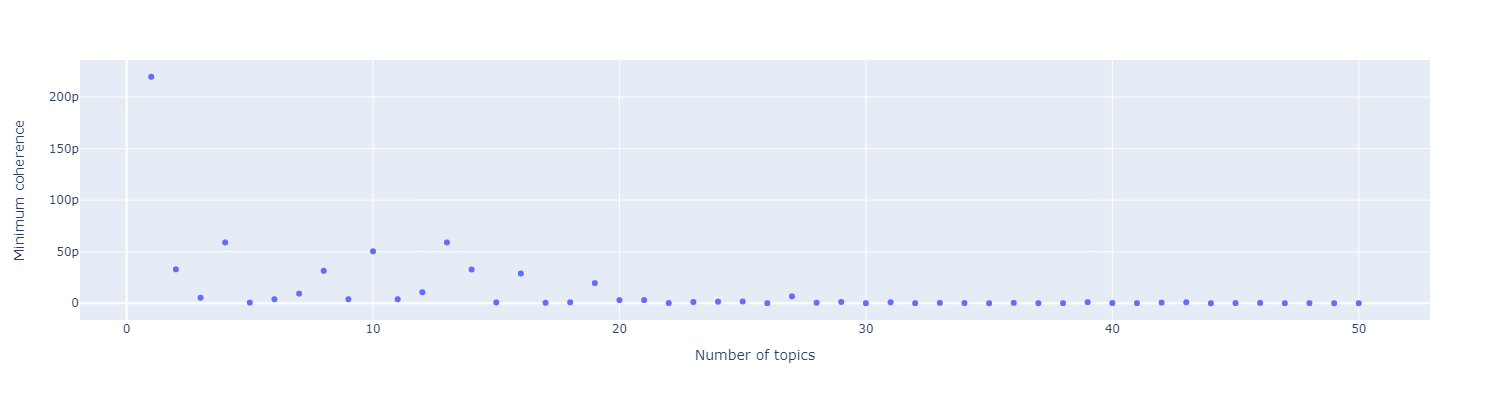

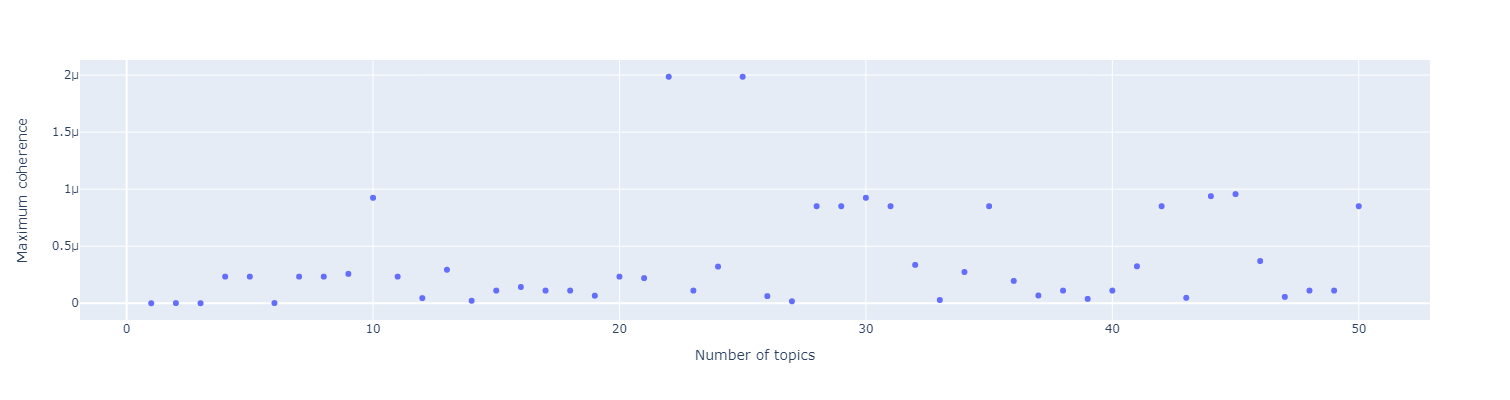

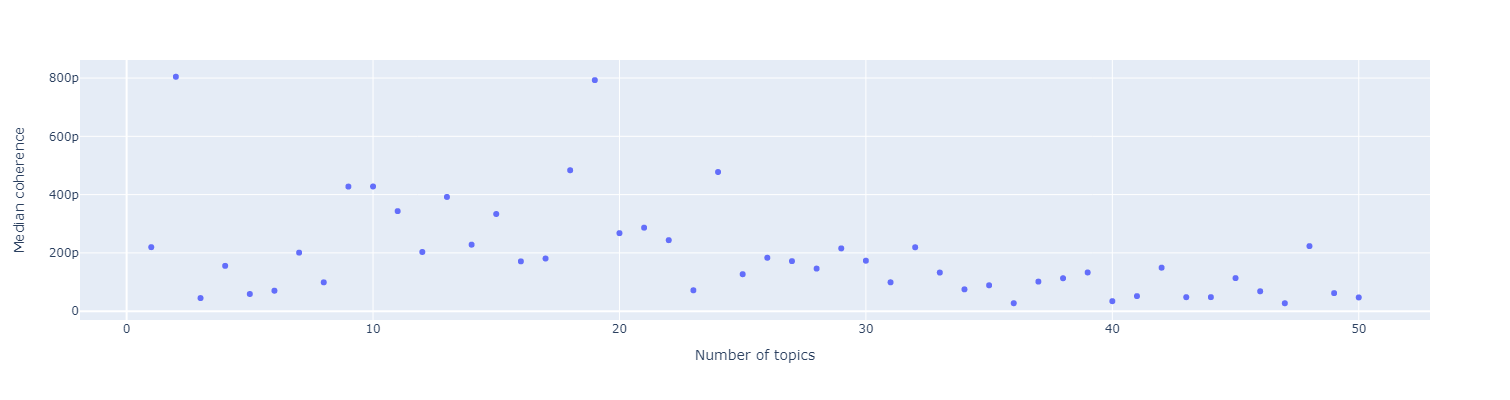

In [342]:
px.scatter(x=numbers_of_topic, y=perplexity_results, log_y=False, labels={"y": "Perplexity (lower is better)", "x": "Number of topics"}, width=700, height=400).show()

px.scatter(x=numbers_of_topic, y=entropy_results, log_y=False, labels={"y": "Entropy (lower is better)", "x": "Number of topics"}, width=700, height=400).show()

px.scatter(x=numbers_of_topic, y=min_coherences, log_y=False, labels={"y": "Minimum coherence", "x": "Number of topics"}, width=700, height=400).show()

px.scatter(x=numbers_of_topic, y=max_coherences, log_y=False, labels={"y": "Maximum coherence", "x": "Number of topics"}, width=700, height=400).show()

px.scatter(x=numbers_of_topic, y=median_coherences, log_y=False, labels={"y": "Median coherence", "x": "Number of topics"}, width=700, height=400).show()

In [138]:
p_zd = model.transform(docs_vec)

p_zd.shape
p_zd

100%|████████████████████████████████████████████████████████████████████████████| 776/776 [00:00<00:00, 129910.59it/s]


array([[8.49591416e-02, 1.26045641e-04, 1.45409835e-04, ...,
        1.37967764e-04, 1.13109395e-04, 1.03856066e-04],
       [3.74187431e-04, 1.32519957e-07, 1.90861098e-07, ...,
        5.47073456e-03, 7.24157856e-03, 1.90272139e-02],
       [1.50299359e-03, 2.37776266e-06, 3.42455886e-06, ...,
        3.00077838e-06, 1.77958349e-06, 1.40140054e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.98512896e-04, 3.14050943e-07, 4.07531351e-04, ...,
        3.96337824e-07, 2.35044431e-07, 3.70374405e-04]])

In [ ]:
# model.biterms_

In [ ]:
# model.matrix_words_topics_.shape

Stable topics: [14, 18]


100%|███████████████████████████████████████████████████████████████████████████| 1059/1059 [00:00<00:00, 92074.54it/s]


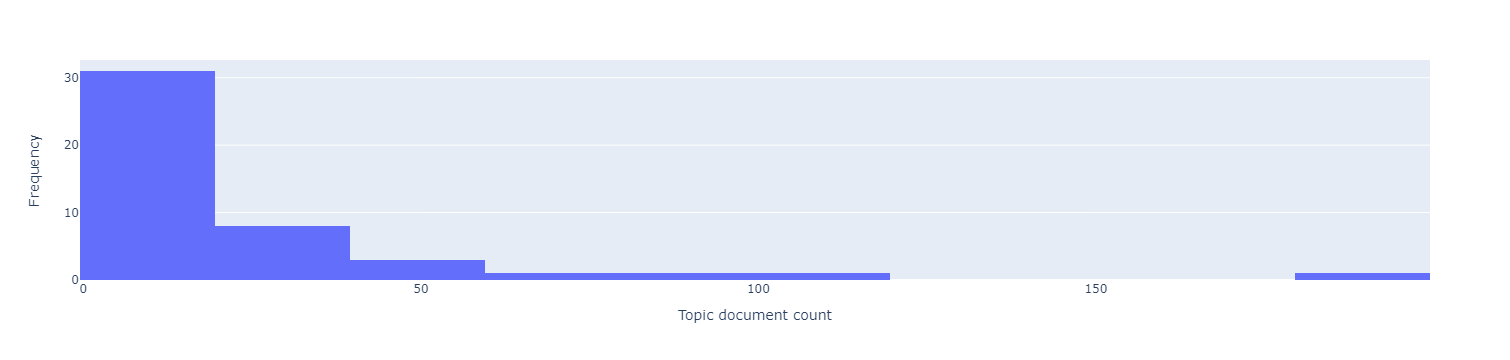

[0, 13, 38, 36, 33, 22, 12, 11, 34, 1]


,topic0,topic13,topic38,topic36,topic33,topic22,topic12,topic11,topic34,topic1
0,file,use,tool,use,support,use,file,use,file,use
1,project,data,use,model,provide,model,use,set,format,file
2,data,machine,project,allow,use,repository,module,model,support,server
3,create,include,code,network,tool,code,also,provide,write,interface
4,analysis,provide,set,tool,run,implementation,make,one,tool,run
5,source,system,build,source,project,contain,format,code,read,application
6,read,support,base,build,also,find,simple,tool,include,develop
7,license,version,write,image,program,paper,build,test,program,feature
8,provide,learn,allow,open,see,source,one,feature,database,system
9,django,format,system,user,server,build,data,analysis,help,allow


Document counts by topic and some examples:
Topic 0: 185 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
1,18F,kubernetes-release,"[[""release"", ""longer_NEG"", ""maintain_NEG"", ""us...",release longer_NEG maintain_NEG use_NEG retain...,7,0
2,3mundi,kaminari-mongoid,"[[""kaminari"", ""mongoid"", ""adapter""]]",kaminari mongoid adapter.,3,0
15,aerospike,aerospike-client-ruby,"[[""aerospike"", ""library"", ""ruby""]]",aerospike library ruby.,3,0
16,aetherknight,recursive-open-struct,"[[""openstruct"", ""subclass"", ""return"", ""nest"", ...",openstruct subclass return nest hash attribute...,7,0
19,ahodesuka,ahoviewer,"[[""gtk"", ""image"", ""viewer"", ""manga"", ""reader"",...",gtk image viewer manga reader booru browser.,7,0
21,airbnb,ruby,"[[""airbnb's"", ""ruby"", ""style"", ""guide""]]",airbnb's ruby style guide.,4,0
26,aliyun,aliyun-oss-ruby-sdk,"[[""alibaba"", ""cloud"", ""os"", ""sdk"", ""ruby""]]",alibaba cloud os sdk ruby.,5,0
28,alphagov,govspeak,"[[""govspeak"", ""markdown-derived"", ""mark-up"", ""...",govspeak markdown-derived mark-up language.,4,0
40,ankane,authtrail,"[[""track"", ""devise"", ""login"", ""activity""]]",track devise login activity.,4,0
43,ankane,lockbox,"[["":p"", ""ackage"", ""modern"", ""encryption"", ""rub...",:p ackage modern encryption ruby rail.,6,0


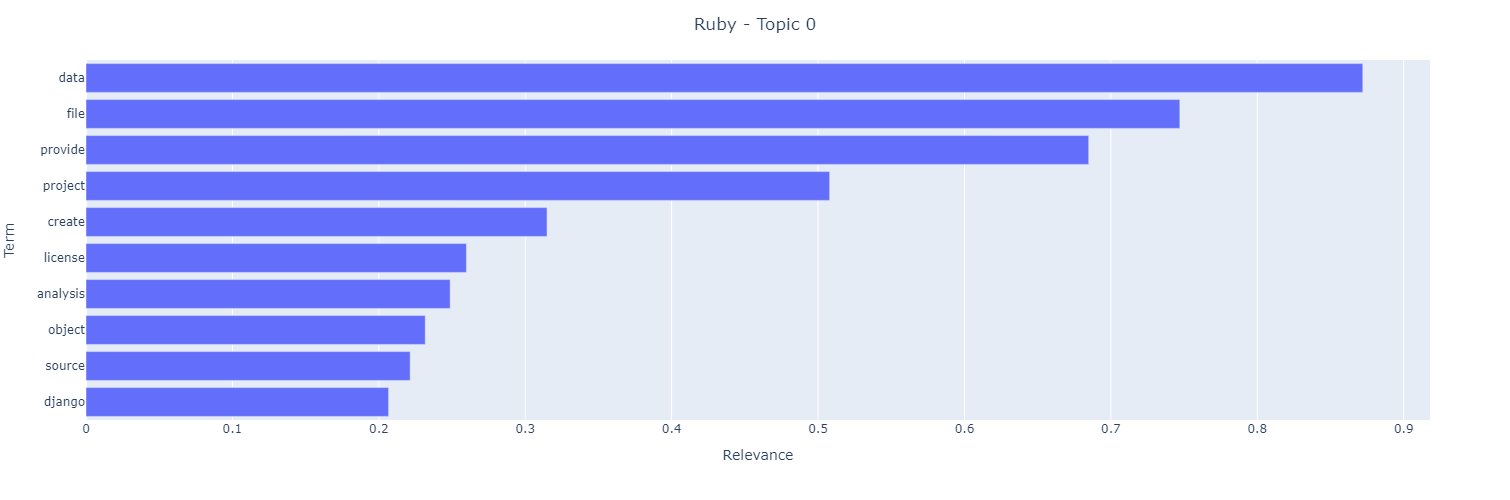

Topic 13: 116 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
9,adacosta,mongoid_rails_migrations,"[[""data"", ""migration"", ""mongoid""]]",data migration mongoid.,3,13
12,adelevie,parse_resource,"[[""unfortunately"", ""able_NEG"", ""give_NEG"", ""li...",unfortunately able_NEG give_NEG library_NEG ti...,12,13
33,amazeeio,pygmy,"[[""pygmy"", ""single"", ""tool"", ""need"", ""get"", ""l...",pygmy single tool need get local amazee.io doc...,23,13
38,andreapavoni,simple_form_fancy_uploads,"[[""set"", ""simple_form"", ""custom"", ""input"", ""ge...",set simple_form custom input get image preview...,10,13
50,apicollective,apibuilder-cli,"[[""command"", ""line"", ""interface"", ""api"", ""buil...",command line interface api builder.,5,13
96,bo-oz,vimeo_me2,"[[""basic"", ""wrapper"", ""vimeo"", ""api"", ""oauth"",...",basic wrapper vimeo api oauth include_NEG code...,23,13
97,boazsegev,combine_pdf,"[[""combinepdf"", ""nifty"", ""model"", ""write"", ""pu...",combinepdf nifty model write pure ruby parse p...,22,13
114,cantino,reckon,"[[""reckon"", ""automagically"", ""convert"", ""csv"",...",reckon automagically convert csv file use comm...,22,13
124,cfabianski,json_translate,"[[""rail"", ""i18n"", ""library"", ""activerecord"", ""...",rail i18n library activerecord model data tran...,24,13
125,cgriego,active_attr,"[[""activeattr"", ""set"", ""module"", ""make"", ""easy...",activeattr set module make easy create plain o...,23,13


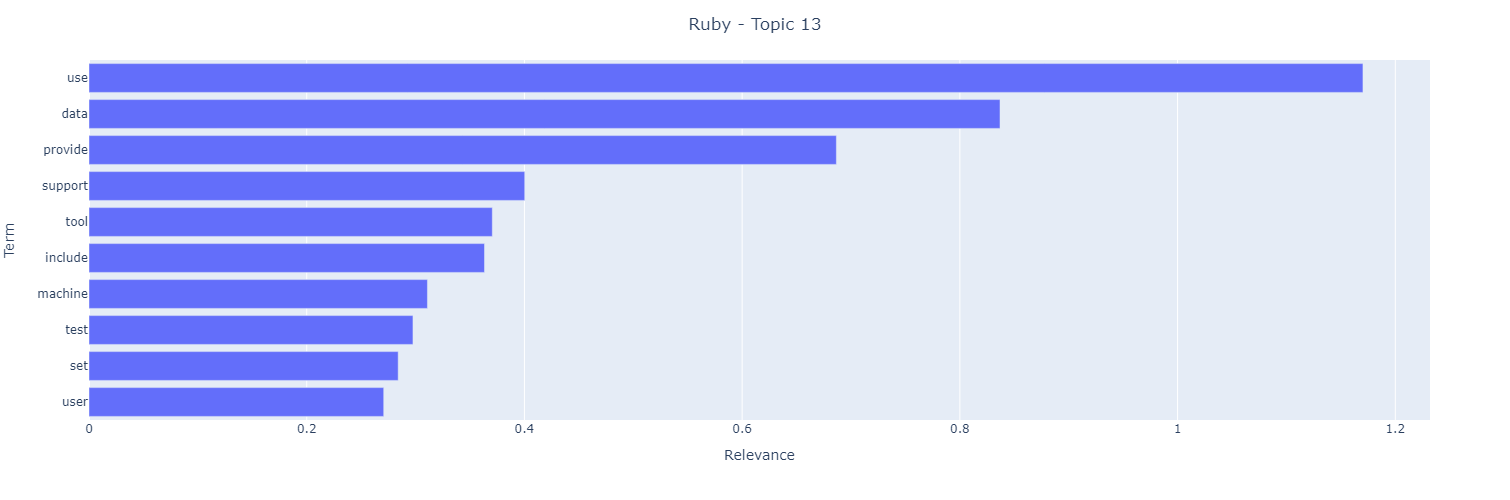

Topic 38: 83 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
0,0x9fff00,futurerestore,"[[""hack"", ""idevicerestore"", ""wrapper"", ""allow""...",hack idevicerestore wrapper allow manually spe...,9,38
14,adzerk,adzerk-api,"[[""ruby"", ""wrapper"", ""adzerk"", ""api""]]",ruby wrapper adzerk api.,4,38
30,amatsuda,database_rewinder,"[[""database_rewinder"", ""minimalist's"", ""tiny"",...",database_rewinder minimalist's tiny ultra-fast...,6,38
41,ankane,distribute_reads,"[[""scale"", ""database"", ""read"", ""replicas"", ""ra...",scale database read replicas rail.,5,38
46,ankane,pgsync,"[[""sync"", ""data"", ""one"", ""postgres"", ""database...",sync data one postgres database another like p...,10,38
62,arturictus,sidekiq_alive,"[[""sidekiqalive"", ""offer"", ""solution"", ""add"", ...",sidekiqalive offer solution add liveness probe...,17,38
75,aws,aws-xray-sdk-ruby,"[[""aws"", ""x-ray"", ""recommends"", ""use"", ""aws"", ...",aws x-ray recommends use aws distro openteleme...,29,38
80,basecamp,marginalia,"[[""attach"", ""comment"", ""activerecord"", ""query""...",attach comment activerecord query default add ...,13,38
86,benjaminoakes,maid,"[[""lazy"", ""let"", ""maid"", ""clean"", ""base"", ""rul...",lazy let maid clean base rule define.,7,38
101,bploetz,versionist,"[[""plugin"", ""versioning"", ""rail"", ""base"", ""res...",plugin versioning rail base restful apis versi...,12,38


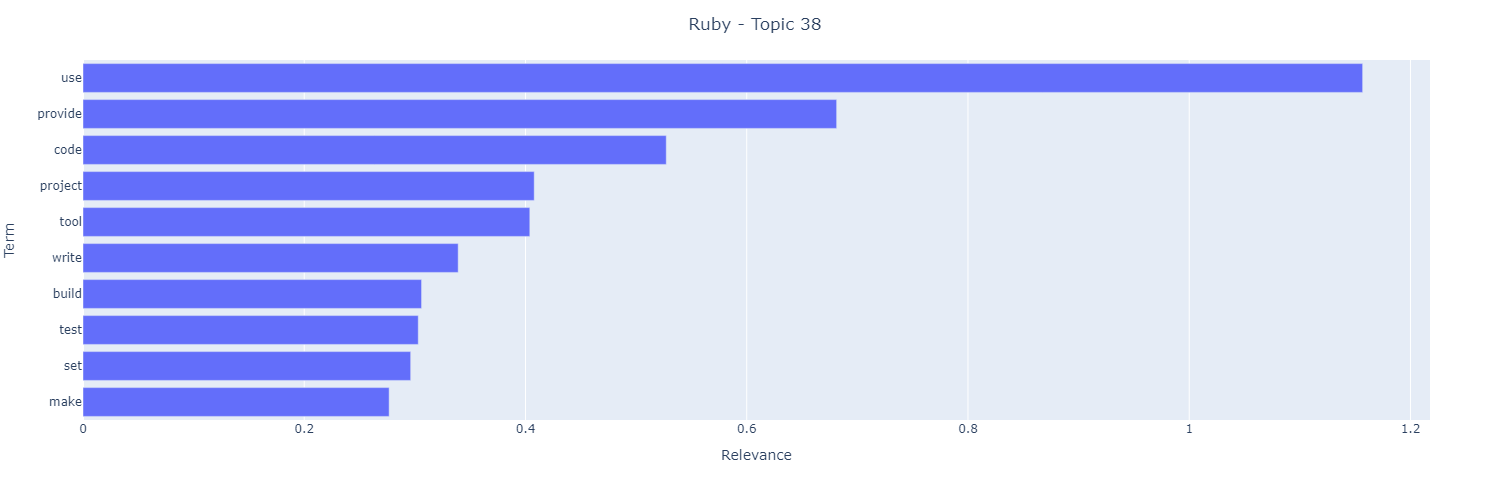

Topic 36: 71 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
6,activeadmin,arbre,"[[""arbre"", ""make"", ""easy"", ""generate"", ""html"",...",arbre make easy generate html directly ruby ge...,11,36
10,adamcooke,authie,"[[""rails"", ""library"", ""provide"", ""application""...",rails library provide application database-bac...,16,36
37,andreapavoni,panoramic,"[[""actionview"", ""resolver"", ""implementation"", ...",actionview resolver implementation store rail ...,15,36
49,anycable,anycable-rails,"[[""anycable"", ""allow"", ""use"", ""websocket"", ""se...",anycable allow use websocket server write lang...,13,36
90,beyonddream,daemons,"[[""daemon"", ""provide"", ""easy"", ""way"", ""wrap"", ...",daemon provide easy way wrap exist ruby script...,19,36
105,braintree,pg_ha_migrations,"[[""document"", ""learned"", ""best"", ""practice"", ""...",document learned best practice apply schema ch...,30,36
109,brunofacca,active-record-query-trace,"[[""display"", ""backtrace"", ""query"", ""rail"", ""de...",display backtrace query rail development conso...,21,36
127,chaps-io,access-granted,"[[""accessgranted"", ""multi-role"", ""whitelist"", ...",accessgranted multi-role whitelist base author...,10,36
128,chaps-io,public_activity,"[[""public_activity"", ""provide"", ""easy"", ""activ...",public_activity provide easy activity track ac...,24,36
137,chef,win32-service,"[[""win"", ""service"", ""library"", ""allow"", ""contr...",win service library allow control create windo...,8,36


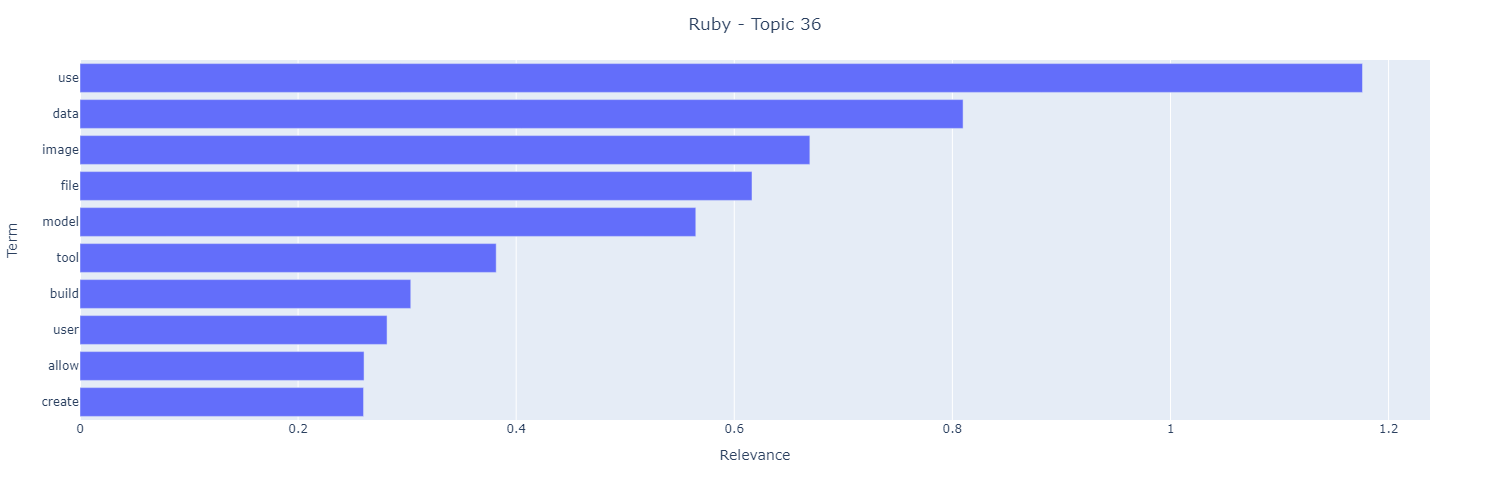

Topic 33: 59 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
47,ankane,searchkick,"[[""rocket"", ""intelligent"", ""search"", ""make"", ""...",rocket intelligent search make easy.,5,33
60,arsduo,koala,"[[""koala"", ""facebook"", ""library"", ""ruby"", ""sup...",koala facebook library ruby support graph api ...,26,33
79,barsoom,attr_extras,"[[""take"", ""boilerplate"", ""ruby"", ""lower"", ""bar...",take boilerplate ruby lower barrier extract sm...,13,33
83,bdurand,lumberjack,"[[""lumberjack"", ""simple"", ""powerful"", ""fast"", ...",lumberjack simple powerful fast logging implem...,18,33
89,betterplace,acts_as_account,"[[""actsasaccount"", ""implement"", ""double"", ""ent...",actsasaccount implement double entry accountin...,7,33
91,bfoz,geometry,"[[""class"", ""method"", ""handling"", ""basic"", ""geo...",class method handling basic geometry learn hig...,9,33
140,chriskite,jimson,"[[""jimson"", ""use"", ""multi_json"", ""load"", ""json...",jimson use multi_json load json library choice...,11,33
144,clio,jit_preloader,"[[""n"", ""query"", ""silent"", ""killer"", ""performan...",n query silent killer performance sometimes no...,13,33
150,cloudfoundry,docs-buildpacks,"[[""guide"", ""developer"", ""use"", ""buildpacks"", ""...",guide developer use buildpacks cloud foundry b...,12,33
151,cloudfoundry,docs-cloudfoundry-concepts,"[[""repository"", ""contain"", ""cloud"", ""foundry"",...",repository contain cloud foundry concept guide...,14,33


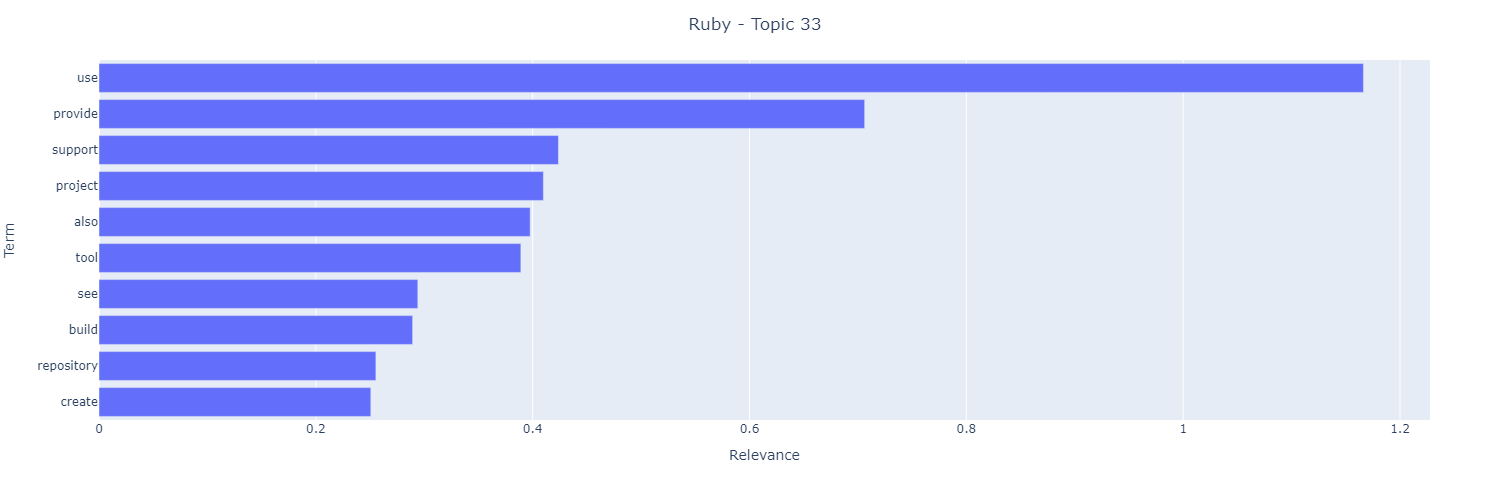

Topic 22: 59 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
8,Ada-Developers-Academy,ada-build,"[[""repository"", ""contain"", ""material"", ""build""...",repository contain material build program part...,16,22
31,amatsuda,html5_validators,"[[""automatic"", ""client-side"", ""validation"", ""u...",automatic client-side validation use html form...,7,22
106,braintree,runbook,"[[""see"", ""blog"", ""post"", ""philosophy"", ""behind...",see blog post philosophy behind runbook overvi...,8,22
119,Casecommons,pg_audit_log,"[[""postgresql-only"", ""database-level"", ""audit""...",postgresql-only database-level audit logging d...,23,22
147,cloudfoundry-incubator,bosh-openstack-cpi-release,"[[""see"", ""initialize"", ""bosh"", ""environment"", ...",see initialize bosh environment openstack exam...,7,22
152,CloudHealth,amazon-pricing,"[[""project"", ""longer_NEG"", ""maintain_NEG"", ""de...",project longer_NEG maintain_NEG deprecate_NEG ...,17,22
154,CocoaPods,cocoapods-downloader,"[[""small"", ""library"", ""download"", ""file"", ""rem...",small library download file remote folder.,6,22
169,ConradIrwin,pry-rescue,"[[""super-fast"", ""debugging"", ""ruby"", ""see"", ""p...",super-fast debugging ruby see pry rescue.,6,22
176,craigw,dns-zonefile,"[[""format"", ""dns"", ""zonefile"", ""define"", ""rfc""...",format dns zonefile define rfc section rfc sec...,13,22
183,customerio,customerio-ruby,"[[""power"", ""automate"", ""communication"", ""peopl...",power automate communication people like receive.,6,22


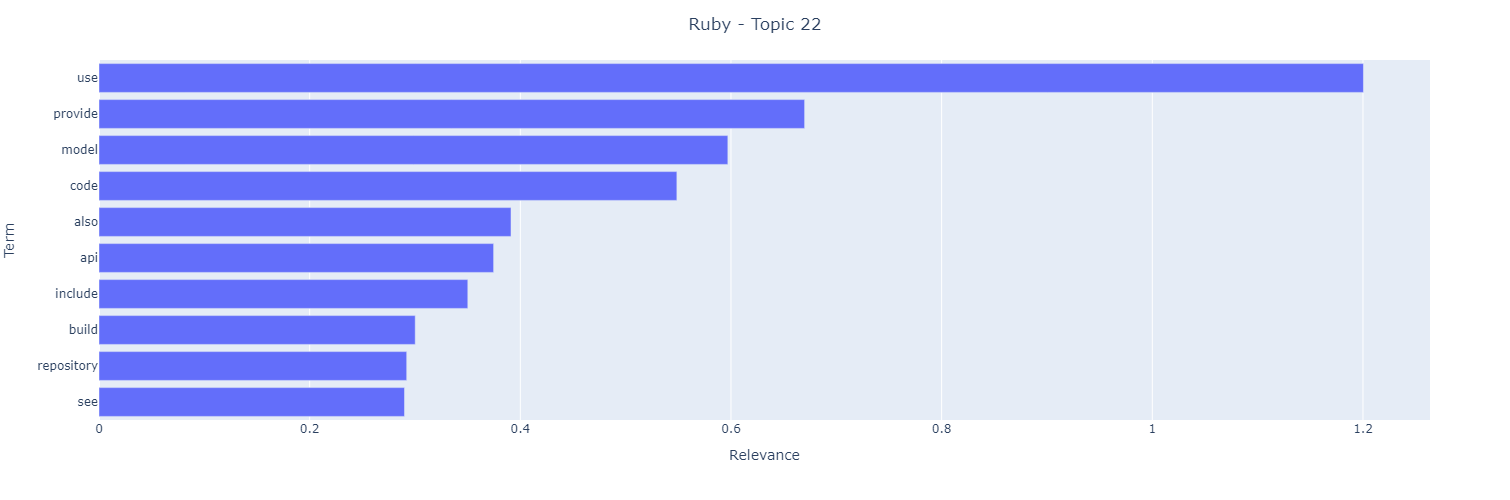

Topic 12: 43 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
61,artofhuman,activeadmin_settings_cached,"[[""provide"", ""nice"", ""ui"", ""interface"", ""rails...",provide nice ui interface rails-settings-cache...,8,12
104,braintree,braintree_ruby,"[[""braintree"", ""gem"", ""provide"", ""integration""...",braintree gem provide integration access brain...,7,12
122,castwide,solargraph,"[[""solargraph"", ""provide"", ""comprehensive"", ""s...",solargraph provide comprehensive suite tool ru...,13,12
136,chef,vagrant-omnibus,"[[""longer_NEG"", ""actively_NEG"", ""maintain_NEG""...",longer_NEG actively_NEG maintain_NEG chef_NEG ...,33,12
192,dannnylo,rtesseract,"[[""ruby"", ""library"", ""work"", ""tesseract"", ""ocr""]]",ruby library work tesseract ocr.,5,12
209,diasks2,pragmatic_segmenter,"[[""pragmatic"", ""segmenter"", ""rule-based"", ""sen...",pragmatic segmenter rule-based sentence bounda...,12,12
219,DmitryTsepelev,store_model,"[[""storemodel"", ""gem"", ""allow"", ""wrap"", ""json-...",storemodel gem allow wrap json-backed db colum...,9,12
262,envato,pagerduty,"[[""provide"", ""lightweight"", ""ruby"", ""interface...",provide lightweight ruby interface call pagerd...,8,12
316,GeorgeKaraszi,ActiveRecordExtended,"[[""active"", ""record"", ""extend"", ""continuation""...",active record extend continuation maintain imp...,12,12
319,github,github-ds,"[[""github"", ""collection"", ""ruby"", ""library"", ""...",github collection ruby library work sql top ac...,9,12


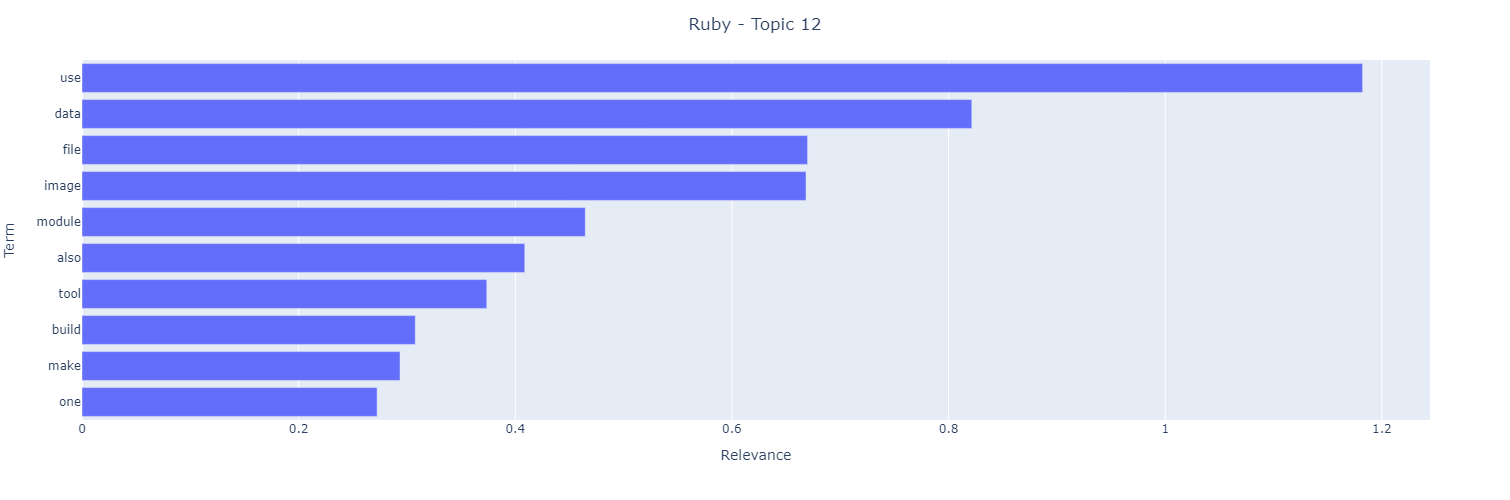

Topic 11: 33 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
7,activemerchant,offsite_payments,"[[""offsite"", ""payment"", ""extraction"", ""ecommer...",offsite payment extraction ecommerce system sh...,29,11
29,amatsuda,active_decorator,"[[""simple"", ""rubyish"", ""view"", ""helper"", ""rail...",simple rubyish view helper rail rail rail rail...,12,11
36,amro,gibbon,"[[""gibbon"", ""api"", ""wrapper"", ""mailchimp's"", ""...",gibbon api wrapper mailchimp's api.,5,11
58,arirusso,ffi-coremidi,"[[""access"", ""apple"", ""core"", ""midi"", ""framewor...",access apple core midi framework api ruby.,7,11
81,basecrm,basecrm-ruby,"[[""basecrm"", ""official"", ""api"", ""v2"", ""library...",basecrm official api v2 library client ruby.,7,11
92,bgarret,google-analytics-rails,"[[""fast"", ""universal"", ""google"", ""analytics"", ...",fast universal google analytics setup rail gem...,15,11
99,bodepd,librarian-puppet-simple,"[[""project"", ""create"", ""frustration"", ""depende...",project create frustration dependency manageme...,25,11
123,cburnette,boxr,"[[""boxr"", ""ruby"", ""client"", ""library"", ""box"", ...",boxr ruby client library box v2 content api bo...,18,11
129,chef,artifactory-client,"[[""ruby"", ""client"", ""interface"", ""artifactory""...",ruby client interface artifactory api majority...,21,11
143,clearbit,clearbit-ruby,"[[""ruby"", ""api"", ""client""]]",ruby api client.,3,11


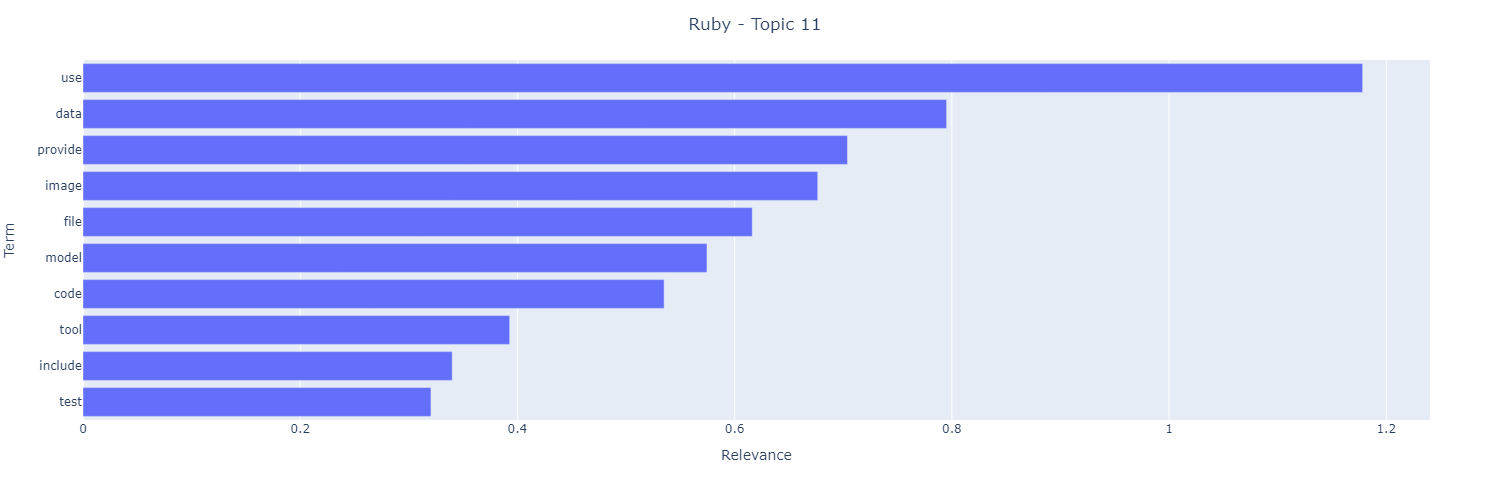

Topic 34: 30 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
18,AfterShip,aftership-sdk-ruby,"[[""ruby"", ""gem"", ""aftership"", ""api""]]",ruby gem aftership api.,4,34
34,ammar,regexp_parser,"[[""ruby"", ""gem"", ""tokenizing"", ""parsing"", ""tra...",ruby gem tokenizing parsing transform regular ...,7,34
53,appfolio,gemsurance,"[[""gemsurance"", ""tool"", ""monitor"", ""ruby"", ""ge...",gemsurance tool monitor ruby gem out-of-date v...,21,34
77,balvig,spyke,"[[""spyke"", ""basically"", ""rip"", ""take"", ""inspir...",spyke basically rip take inspiration innocent ...,17,34
95,bluepill-rb,bluepill,"[[""bluepill"", ""simple"", ""process"", ""monitor"", ...",bluepill simple process monitor tool write ruby.,7,34
113,cainlevy,snail,"[[""international"", ""snail"", ""mail"", ""addressin...",international snail mail addressing pain gem b...,9,34
258,enkessler,childprocess,"[[""gem"", ""aim"", ""simple"", ""reliable"", ""solutio...",gem aim simple reliable solution control exter...,13,34
282,fedora-ruby,gem2rpm,"[[""gem"", ""2rpm"", ""convert"", ""rubygems"", ""packa...",gem 2rpm convert rubygems package rpm spec file.,8,34
303,forward3d,rbhive,"[[""rbhive"", ""simple"", ""ruby"", ""gem"", ""communic...",rbhive simple ruby gem communicate apache hive...,9,34
312,gel-rb,gel,"[[""modern"", ""gem"", ""manager""]]",modern gem manager.,3,34


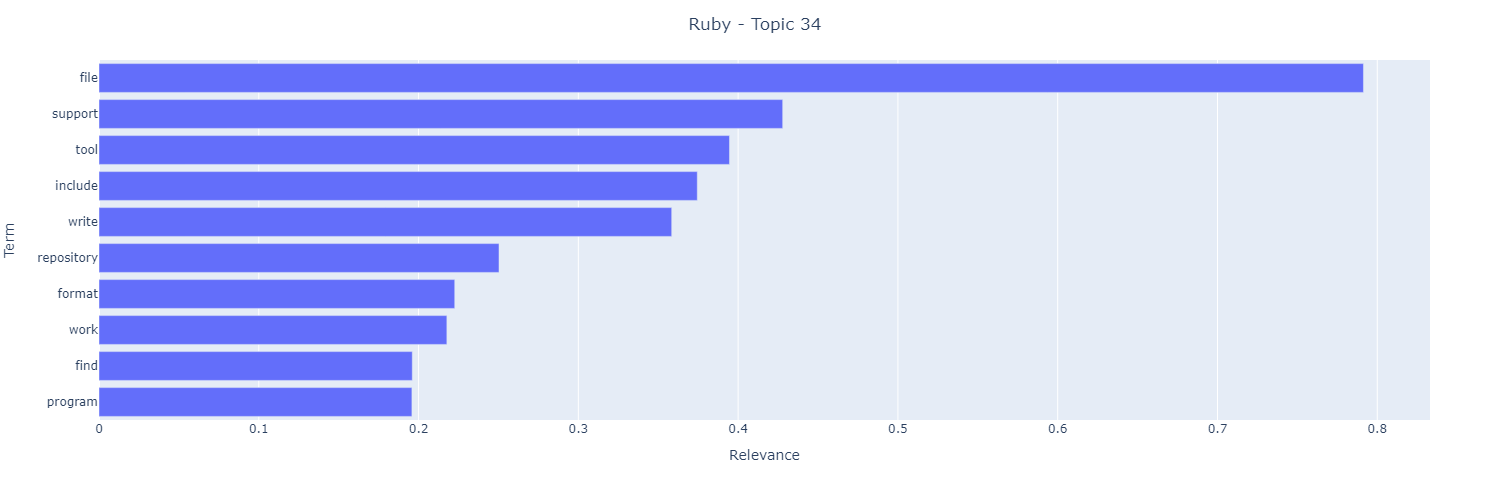

Topic 1: 29 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
24,albertbellonch,piet,"[[""piet"", ""gem"", ""optimize"", ""image"", ""store"",...",piet gem optimize image store file integration...,9,1
35,amoeba-rb,amoeba,"[[""easy"", ""cloning"", ""active_record"", ""object""...",easy cloning active_record object include asso...,10,1
98,boazsegev,iodine,"[[""iodine"", ""fast"", ""concurrent"", ""web"", ""appl...",iodine fast concurrent web application server ...,17,1
175,cpetersen,srt,"[[""srt"", ""stand"", ""subrip"", ""text"", ""file"", ""f...",srt stand subrip text file format file store s...,24,1
206,devopsgroup-io,vagrant-hostmanager,"[[""vagrant-hostmanager"", ""vagrant"", ""plugin"", ...",vagrant-hostmanager vagrant plugin manage host...,22,1
248,dwilkie,carrierwave_direct,"[[""carrierwave"", ""great"", ""way"", ""upload"", ""fi...",carrierwave great way upload file ruby applica...,23,1
279,fastly,fastly-ruby,"[[""client"", ""library"", ""interact"", ""fastly"", ""...",client library interact fastly web acceleratio...,8,1
348,guard,guard-rspec,"[[""guard"", ""rspec"", ""allow"", ""automatically"", ...",guard rspec allow automatically intelligently ...,9,1
349,guard,listen,"[[""listen"", ""gem"", ""listen"", ""file"", ""modifica...",listen gem listen file modification notifies c...,7,1
360,hanami,utils,"[[""ruby"", ""core"", ""extension"", ""class"", ""utili...",ruby core extension class utility hanami.,6,1


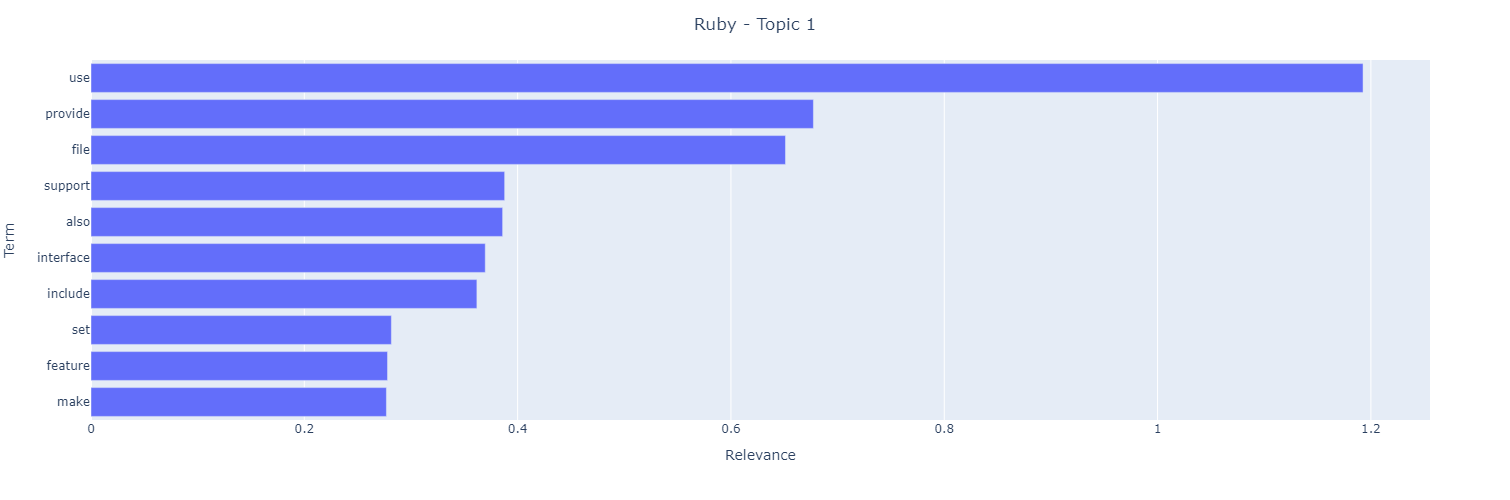

In [352]:
mean_coherence = statistics.mean(coherences)    

stable_topics = []
for topic_id, topic_coherence in enumerate(coherences):
    if topic_coherence >= mean_coherence:
    # if topic_coherence > 0:
        stable_topics.append(topic_id)
        
print("Stable topics:", stable_topics)

def classify_doc(likelihoods, stable_topics=None):
    if stable_topics is None:
        stable_topics = list(range(0, likelihoods.shape[0]))
    filtered_max = max([likelihood for topic_id, likelihood in enumerate(likelihoods) if topic_id in stable_topics])
    return np.where(likelihoods == filtered_max)[0][0]

def get_top_n_topics(topic_doc_counts, n):
    top_n = sorted(topic_doc_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    return [topic[0] for topic in top_n]

def get_top_n_terms(model, topic_id, n, lambda_=0.6, return_df=True, plot=True):
    phi = tmp.get_phi(model)
    terms_probs = tmp.calc_terms_probs_ratio(phi, topic=topic_id, lambda_=lambda_)
    terms_probs

    term_relevances = {}
    for term in terms_probs.Terms.unique():
        marginal_prob = terms_probs[(terms_probs.Terms == term) & (terms_probs.Type == "Marginal term probability, p(w)")]["Probability"].values[0]
        conditional_prob = terms_probs[(terms_probs.Terms == term) & (terms_probs.Type == "Conditional term probability, p(w|t)")]["Probability"].values[0]
        
        # conditional_prob = phi.loc[term, topic_id] / phi[topic_id].sum()
        # marginal_prob = phi.loc[term, topic_id] / phi.loc[term,].sum()
        
        term_relevances[term] = conditional_prob * lambda_ + marginal_prob * (1-lambda_)
    term_relevances = dict(sorted(term_relevances.items(), key=lambda x: x[1], reverse=True))
    top_terms = dict(itertools.islice(term_relevances.items(), n))
    top_terms = pd.DataFrame(top_terms.items(), columns=["Term", "Relevance"])
    
    if plot:
        px.bar(top_terms, x="Relevance", y="Term", orientation="h", width=500, height=500).update_yaxes(autorange="reversed").update_layout(title_text=f"{language} - Topic {topic_id}", title_x=0.5).show()
    
    if return_df:
        return top_terms

docs_topic_likelihoods = model.transform(docs_vec)

repos["TOPIC"] = [classify_doc(likelihoods, stable_topics=None) for likelihoods in docs_topic_likelihoods]

topic_doc_counts = repos["TOPIC"].value_counts().to_dict()

# for topic, count in topic_doc_counts.items():
#     print(topic, count)

px.histogram(repos["TOPIC"].value_counts(), width=600, height=300).update_layout(showlegend=False, yaxis_title="Frequency", xaxis_title="Topic document count").show()

top_topics = get_top_n_topics(topic_doc_counts, 10)

print(top_topics)

# repos[repos.TOPIC == "5"]

display(btm.get_top_topic_words(model, words_num=10, topics_idx=top_topics))

pd.set_option('display.width', 2000)

print("Document counts by topic and some examples:")
for topic in top_topics:
    print(f"Topic {topic}: {topic_doc_counts[topic]} repos")
    display(repos[repos.TOPIC == topic][0:10])
    get_top_n_terms(model, topic_id=topic, n=10, lambda_=0.6, return_df=False, plot=True)

In [353]:
phi = tmp.get_phi(model)
# phi = phi.loc[(phi!=0).any(axis=1)]
phi.style.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")
# terms_probs = tmp.calc_terms_probs_ratio(phi, topic=0, lambda_=0.6)
# terms_probs

topics,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
words,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
access,0.000015,0.000004,0.000018,0.000007,0.000007,0.000004,0.000031,0.000017,0.000041,0.000037,0.000007,0.000004,0.000004,0.000001,0.000009,0.000010,0.000004,0.000017,0.000008,0.000027,0.000004,0.000018,0.000003,0.000004,0.000007,0.000003,0.000013,0.000014,0.000009,0.000003,0.000005,0.000011,0.000004,0.000002,0.000008,0.000006,0.000002,0.000014,0.000002,0.000005,0.000007,0.000007,0.000006,0.000011,0.000007,0.000004,0.000037,0.000014,0.000005,0.000010
add,0.000015,0.000004,0.000018,0.000007,0.000007,0.000004,0.000031,0.000017,0.000041,0.007532,0.000007,0.000004,0.000004,0.000001,0.000009,0.004786,0.033516,0.000017,0.000008,0.000027,0.000004,0.000018,0.000003,0.000004,0.000007,0.008680,0.110566,0.000014,0.010910,0.023941,0.000005,0.000011,0.000004,0.000002,0.001538,0.000006,0.000002,0.000014,0.020107,0.029813,0.020174,0.000007,0.013969,0.041907,0.000007,0.000004,0.130216,0.000014,0.012752,0.000010
allow,0.000015,0.037944,0.000018,0.000007,0.000007,0.020196,0.000031,0.000017,0.000041,0.000037,0.000007,0.000004,0.028739,0.000143,0.005430,0.054458,0.000004,0.000017,0.000008,0.000027,0.000004,0.001854,0.007628,0.000004,0.000007,0.079957,0.000013,0.000014,0.000009,0.022366,0.000005,0.000011,0.000004,0.016853,0.000008,0.000006,0.052565,0.079156,0.034992,0.000005,0.000007,0.000007,0.000006,0.000011,0.000007,0.009575,0.089303,0.000014,0.030810,0.000010
also,0.000015,0.025160,0.000018,0.000007,0.070833,0.038971,0.058518,0.000017,0.000041,0.000037,0.000007,0.000004,0.063140,0.000001,0.000009,0.000010,0.000004,0.000017,0.000008,0.035463,0.000004,0.000018,0.033856,0.047098,0.047054,0.000003,0.000013,0.000014,0.051787,0.044100,0.080827,0.000011,0.020545,0.044703,0.000008,0.000006,0.000002,0.000014,0.000002,0.019380,0.000007,0.052428,0.000006,0.000011,0.000007,0.000004,0.159972,0.000014,0.032934,0.000010
analysis,0.065721,0.000004,0.000018,0.017193,0.000007,0.000004,0.000031,0.000017,0.000041,0.138687,0.000007,0.051912,0.000004,0.009231,0.003623,0.000010,0.000004,0.000017,0.000008,0.000027,0.000004,0.172540,0.000003,0.000004,0.000007,0.000003,0.000013,0.000014,0.000009,0.000003,0.000005,0.000011,0.000004,0.018257,0.000008,0.000006,0.007565,0.000014,0.000002,0.000005,0.000007,0.035408,0.000006,0.000011,0.000007,0.000004,0.000037,0.000014,0.002661,0.000010
api,0.000015,0.000004,0.000018,0.000007,0.000007,0.000004,0.000031,0.000017,0.000041,0.168665,0.026417,0.000004,0.000004,0.000427,0.000009,0.000010,0.035560,0.000017,0.000008,0.000027,0.000004,0.000018,0.021962,0.064511,0.000007,0.063842,0.000013,0.207089,0.000009,0.000003,0.000005,0.000011,0.000004,0.000002,0.000008,0.000006,0.000002,0.000014,0.020300,0.000005,0.000007,0.000007,0.002333,0.000011,0.054797,0.000004,0.000037,0.237371,0.000005,0.000010
application,0.000015,0.047430,0.000018,0.000007,0.000007,0.000004,0.000031,0.000017,0.000041,0.000037,0.000007,0.000004,0.000004,0.000001,0.000009,0.000010,0.034742,0.000017,0.000008,0.000027,0.029092,0.000018,0.000003,0.017417,0.000007,0.036261,0.000013,0.000014,0.000009,0.000003,0.000005,0.000011,0.012892,0.023406,0.002303,0.000006,0.014183,0.023210,0.033639,0.000005,0.053038,0.000007,0.000006,0.000011,0.000007,0.000004,0.000037,0.000014,0.045681,0.000010
base,0.000015,0.000004,0.000018,0.064124,0.049847,0.020904,0.000031,0.000017,0.000041,0.000037,0.055607,0.000004,0.000004,0.009089,0.000009,0.076429,0.000004,0.000017,0.000008,0.002753,0.000823,0.000018,0.016167,0.000004,0.000007,0.000003,0.000013,0.000014,0.000009,0.000003,0.031126,0.000011,0.037461,0.000002,0.000008,0.000006,0.025905,0.000014,0.039245,0.000005,0.022415,0.000007,0.000006,0.000011,0.013157,0.000004,0.000037,0.000014,0.000005,0.000010
based,0.000015,0.000004,0.000018,0.000007,0.000007,0.000004,0.000031,0.000017,0.000041,0.000037,0.000007,0.000004,0.000004,0.000001,0.000009,0.00

In [354]:
tmp.report(model=model, docs=texts)